## Corpus Encoding and Image Comparison

- Code in this notebook uses the feature extractor to encode corpus of fine art 
- A test street art image is then compared to the corpus using cosine distance to find the best matches

### Imports

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import pickle
import json

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Input
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
import matplotlib.pyplot as plt

from scipy import spatial

from IPython.display import display, Image

Using TensorFlow backend.
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: Future

In [3]:
# Load autoencoder
autoencoder = load_model('./autoencoder/models/autoencoder.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [4]:
# Load feature extractor.
feature_extractor = load_model('./autoencoder/models/feature_extractor.h5')

//anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Convert Images into Tensors

In [5]:
# Convert corpus of original images into tensors
# Parameters
image_dimension = 200
batch_size = 10000

In [7]:
# Functions to convert images to 3D (image_dim, image_dim, 3) 
# or 4D (1, image_dim, image_dim, 3) tensors

def image_to_3d_tensor(image_path):
    im = cv2.resize(cv2.imread(image_path), (image_dimension, image_dimension)).astype(np.float32)
    return im/255

def image_to_4d_tensor(image_path):
    im = image_to_3d_tensor(image_path)
    im = im.reshape(1, image_dimension, image_dimension, 3)
    return im

In [ ]:
# Corpus directory
corpus_image_directory = './autoencoder/all_data/'
corpus_image_count = len([name for name in os.listdir(corpus_image_directory)])
print(corpus_image_count)

In [ ]:
# Instantiate tensors array and list of filenames
corpus_tensors = np.zeros((1, image_dimension, image_dimension, 3))
corpus_tensors_list = []
corpus_filenames = []

In [ ]:
# Create image tensors and filename list
for filename in os.listdir(corpus_image_directory):
    corpus_filenames.append(filename)
    try: 
        corpus_tensors_list.append(image_to_3d_tensor(corpus_image_directory + filename))
    except: 
        pass
    if len(corpus_tensors_list) % 50 == 0: print('Processed:', len(corpus_tensors_list)) 
corpus_tensors = np.array(corpus_tensors_list)

In [ ]:
# Save tensors and filenames
pickle.dump(corpus_tensors, open('./autoencoder/models/corpus_tensors.pickle', 'wb'), protocol=4)
pickle.dump(corpus_filenames, open('./autoencoder/models/corpus_filenames.pickle', 'wb'))

In [ ]:
# View dimensions of corpus tensors
corpus_tensors.shape

In [ ]:
# Predict feature values using narrow encoded layer
corpus_features = feature_extractor.predict(corpus_tensors, verbose=1)

In [ ]:
# Save corpus features
pickle.dump(corpus_features, open('./autoencoder/models/corpus_features.pickle', 'wb'), protocol=4)

### Display Original and Autoencoded Images

In [12]:
# Load filenames
corpus_filenames = pickle.load(open('./autoencoder/models/corpus_filenames.pickle', 'rb'))

In [13]:
# Load corpus metadata
corpus_metadata = pd.read_json('./autoencoder/models/corpus_metadata_final.json')

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def display_orig_and_encoded(image):
    orig = image_to_3d_tensor(image)
    pred = autoencoder.predict(orig.reshape(1, image_dimension, image_dimension, 3))\
            .reshape(image_dimension, image_dimension, 3)
    # print(orig.shape, pred.shape)
    plt.figure(figsize=(12, 10))
    plt.subplot(221)
    plt.imshow(orig)
    plt.title('Original')
    plt.subplot(222)
    plt.imshow(pred)
    plt.title('Encoded')

In [ ]:
display_orig_and_encoded('./street_art_test_images/pichiavo_patron_of_arts_tel_aviv.jpg')

### Compare Test Image to Corpus

In [18]:
def compare_test_image(test_image_file, metric='cosine'):
    
    # Display original image
    print('Original image')
    display(Image(test_image_file, width = image_dimension, height = image_dimension))
    
    # Predict feature values for test image
    test_tensor = image_to_4d_tensor(test_image_file)
    test_features = feature_extractor.predict(test_tensor)
    
    # Use a vectorized function (spatial.distance.cdist) to calculate the distance between
    # the test image and each of the images in the corpus.
    # Images need to be converted to '2d' for use in distance.cdist.
    # First dimension is number of images (1 for test, corpus size for corpus).
    # Second dimension is width x height x number of color channels.
    test_features_2d = np.reshape(test_features, (test_features.shape[0], test_features.shape[1] * test_features.shape[2] * test_features.shape[3]))
    corpus_features_2d = np.reshape(corpus_features, (corpus_features.shape[0], corpus_features.shape[1] * corpus_features.shape[2] * corpus_features.shape[3]))
    
    # Run comparison
    distance_array = spatial.distance.cdist(test_features_2d, corpus_features_2d, metric=metric)

    # If #1 best match is indistinguishable from test image, skip 
    shift = 0
    if np.min(distance_array) < .001: shift = 1
        
    # Return top 5 id numbers using argsort
    top5ids = [int(corpus_filenames[index][:-4]) for index in distance_array.argsort()[0][0+shift:5+shift].tolist()]
    top5list = []
    
    print('Closest matches')
    for index, value in enumerate(top5ids):
        artwork = {}
        artwork['order'] = index
        artwork['image_url'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'image_url'].item()
        artwork['artist'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'artist'].item()
        artwork['title'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'title'].item()
        artwork['date'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'date'].item()
        artwork['medium'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'medium'].item()
        artwork['page_url'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'page_url'].item()
        artwork['resubmit'] = 'placeholder'
        top5list.append(artwork)
        display(Image(url = artwork['image_url'], format = 'jpg', width = image_dimension, height = image_dimension))
    return(top5list)

Original image


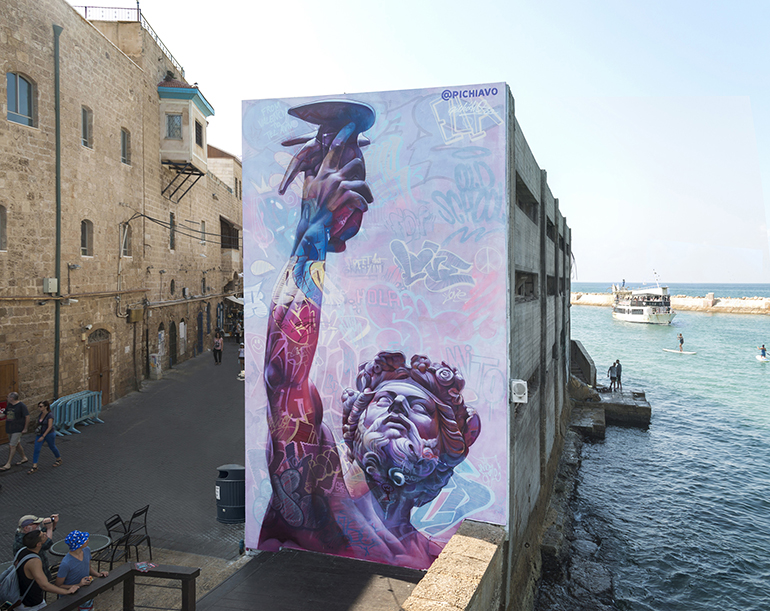

Closest matches


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: `item` has been deprecated and will be removed in a future version
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: `item` has been deprecated and will be removed in a future version
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: `item` has been deprecated and will be removed in a future version
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: `item` has been deprecated and will be removed in a future version
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: `item` has been deprecated and will be removed in a future version
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: FutureWarning: `item` has been deprecated and will be removed in a future version


In [19]:
# Execute comparison for test image.
top5 = compare_test_image('./street_art_test_images/pichiavo_patron_of_arts_tel_aviv.jpg')

In [20]:
# View associated metadata for returned images
top5

[{'order': 0,
  'image_url': 'http://www.moma.org/media/W1siZiIsIjY5MzMyIl0sWyJwIiwiY29udmVydCIsIi1yZXNpemUgMzAweDMwMFx1MDAzZSJdXQ.jpg?sha=175e4cece3cf95c0',
  'artist': 'Yves Tanguy',
  'title': 'The Furniture of Time',
  'date': '1939',
  'medium': 'Oil on canvas',
  'page_url': 'http://www.moma.org/collection/works/80625',
  'resubmit': 'placeholder'},
 {'order': 1,
  'image_url': 'http://www.moma.org/media/W1siZiIsIjE2OTA1OCJdLFsicCIsImNvbnZlcnQiLCItcmVzaXplIDMwMHgzMDBcdTAwM2UiXV0.jpg?sha=a40619d2fd303ba7',
  'artist': 'Robert Smithson',
  'title': 'Alogon #2',
  'date': '1966',
  'medium': 'Painted steel, ten units',
  'page_url': 'http://www.moma.org/collection/works/81087',
  'resubmit': 'placeholder'},
 {'order': 2,
  'image_url': 'http://www.moma.org/media/W1siZiIsIjE1MTE0NiJdLFsicCIsImNvbnZlcnQiLCItcmVzaXplIDMwMHgzMDBcdTAwM2UiXV0.jpg?sha=477cde7bf7415b48',
  'artist': 'Odilon Redon',
  'title': 'The Black Sun',
  'date': 'c. 1900',
  'medium': 'Oil with incising on board',
  